<a href="https://colab.research.google.com/github/Prisze/AAI-511FinalProject/blob/main/Final_MIDI_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/Mozart/
  inflating: dataset/Mozart/K317 Coronation Mass 6mov.mid  
  inflating: dataset/Mozart/K608 Fantasia for Mechanical Organ.mid  
  inflating: dataset/Mozart/K525 Serenade 4mov ''Eine Kleine Natchmusik''.mid  
  inflating: dataset/Mozart/K495 Horn Concerto n4 2mov.mid  
  inflating: dataset/Mozart/K393 Solfeggi n4.mid  
  inflating: dataset/Mozart/K136 Divertimento 3mov.mid  
  inflating: dataset/Mozart/K393 Solfeggi n3.mid  
  inflating: dataset/Mozart/Contradance n1.mid  
  inflating: dataset/Mozart/Sonatina n3 3mov.mid  
  inflating: dataset/Mozart/K527 Overture ''Don Giovanni''.mid  
  inflating: dataset/Mozart/K495 Horn Concerto n4 3mov.mid  
  inflating: dataset/Mozart/K617 Adagio.mid  
   creating: dataset/Mozart/Piano Sonatas/
  inflating: dataset/Mozart/Piano Sonatas/Piano Sonata n07 K309.mid  
  inflating: dataset/Mozart/Piano Sonatas/Piano Sonata n04 K282.mid  
  inflating: dataset/Mozart/Piano Sonatas/P

In [ ]:
!pip -q install pretty_midi

In [ ]:
import glob
paths = glob.glob('dataset/**/*.mid', recursive=True)

In [ ]:
len(paths)

1530

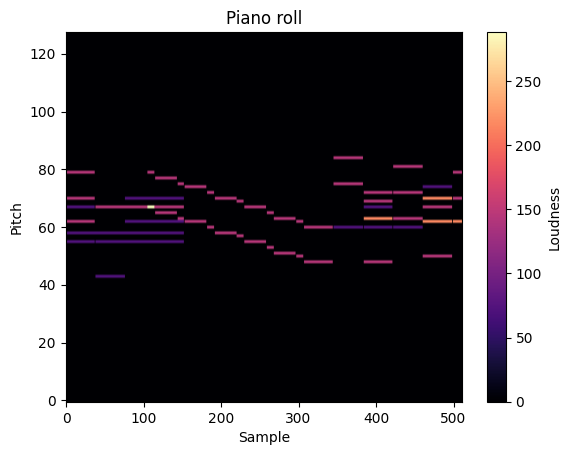

In [ ]:
import pretty_midi
midi_data = pretty_midi.PrettyMIDI(paths[0])

piano_roll = midi_data.get_piano_roll(fs=64)

from matplotlib import pyplot as plt
plt.imshow(
    piano_roll[:, :512],
    aspect='auto',
    origin='lower',
    cmap='magma'
)
plt.xlabel('Sample')
plt.ylabel('Pitch')
plt.title('Piano roll')
plt.colorbar(label='Loudness')
plt.show()

In [ ]:
from collections import defaultdict
from pathlib import Path
import random
import numpy as np
import pretty_midi
import tqdm

FS = 64
TARGET_N_PER_COMPOSER = 1_843_200 # 8 hours @ FS = 64

groups = defaultdict(list)
for p in paths:
  parts = Path(p).parts
  if len(parts) > 1:
    groups[parts[1]].append(p)

midis = {k: [] for k in groups}
totals = {k: 0  for k in groups}

for composer, plist in groups.items():
  random.shuffle(plist)
  with tqdm.tqdm(total=TARGET_N_PER_COMPOSER, desc=f'{composer}', unit='frames') as pbar:
    for path in plist:
      if totals[composer] >= TARGET_N_PER_COMPOSER:
        break
      try:
        # Load track
        midi = pretty_midi.PrettyMIDI(path)
        roll = midi.get_piano_roll(fs=FS).astype(np.float32)

        # Normalize amplitude
        mx = roll.max()
        if mx > 0:
          roll = roll / mx

        N = int(roll.shape[1])
        remain = TARGET_N_PER_COMPOSER - totals[composer]
        if N <= 0 or remain <= 0:
          continue

        if N <= remain:
          midis[composer].append(roll)
          totals[composer] += N
          pbar.update(N)
        else:
          midis[composer].append(roll[:, :remain])
          totals[composer] += remain
          pbar.update(remain)
          break

      except Exception as e:
        print(f'Skipping "{path}"')
        continue

  if totals[composer] < TARGET_N_PER_COMPOSER:
    print(f'Warning: {composer} reached only {totals[composer]}/{TARGET_N_PER_COMPOSER} frames.')

print('')
for composer, total in totals.items():
  print(f"{composer}: total N = {total} ({len(midis[composer])} clips)")


Mozart:  12%|█▏        | 224710/1843200 [00:03<00:24, 65129.36frames/s]/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Beethoven: 100%|██████████| 1843200/1843200 [00:23<00:00, 78981.53frames/s]


Mozart: total N = 1843200 (74 clips)
Bach: total N = 1843200 (204 clips)
Chopin: total N = 1843200 (131 clips)
Beethoven: total N = 1843200 (63 clips)


In [ ]:
from sklearn.model_selection import train_test_split

X, y = [], []
for label, samples in midis.items():
  for s in samples:
    X.append(s)
    y.append(label)

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

def rebuild(xs, ys):
  out = {}
  for s, lbl in zip(xs, ys):
    out.setdefault(lbl, []).append(s)
  return out

train_data, test_data = rebuild(X_train, y_train), rebuild(X_test, y_test)

In [ ]:
for key, arr_list in train_data.items():
    total_N = sum(arr.shape[1] for arr in arr_list)
    print(f'{key}: total N = {total_N}')


Bach: total N = 1466818
Chopin: total N = 1349266
Beethoven: total N = 1409106
Mozart: total N = 1457362


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ChunkedMidiDataset(Dataset):
  def __init__(self, data, chunk_width):
    super().__init__()

    pairs = [(s, lbl) for lbl, lst in data.items() for s in lst]
    labels = sorted({lbl for _, lbl in pairs})
    self.label_to_id = {lbl: i for i, lbl in enumerate(labels)}
    self.id_to_label = {v: k for k, v in self.label_to_id.items()}
    self.chunk_width = int(chunk_width)

    self._chunks = []
    self._labels = []

    for arr, lbl in pairs:
      T = arr.shape[1]
      n_chunks_in_sample = T // self.chunk_width
      if n_chunks_in_sample == 0:
        print('Warning: skipping sample with length less than chunk width')
        continue

      for k in range(n_chunks_in_sample):
        start = k * self.chunk_width
        stop = start + self.chunk_width
        chunk = arr[:, start:stop]
        chunk_t = torch.from_numpy(chunk).to(torch.float32)
        self._chunks.append(chunk_t)
        self._labels.append(self.label_to_id[lbl])

  def __len__(self):
    return len(self._chunks)

  def __getitem__(self, idx):
    return self._chunks[idx], self._labels[idx]

train_ds = ChunkedMidiDataset(train_data, chunk_width=512)
test_ds  = ChunkedMidiDataset(test_data,  chunk_width=512)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

CNN_DEFAULT_CONFIG = [
    {'c': 16, 'k': (3, 7), 's': (1, 2), 'p': (1, 3)},
    {'c': 32, 'k': (3, 5), 's': (1, 2), 'p': (1, 2)},
    {'c': 64, 'k': (3, 3), 's': (1, 2), 'p': (1, 1)},
]

class MidiCNN(nn.Module):
  def conv_block(self, in_c, c, k, s, p):
    return nn.Sequential(
      nn.Conv2d(in_c, c, kernel_size=k, stride=s, padding=p, bias=False),
      nn.BatchNorm2d(c),
      nn.ReLU(inplace=True),
    )

  def __init__(self, num_classes=4, blocks=CNN_DEFAULT_CONFIG, dropout=0.1):
    super().__init__()

    cnn_blocks = []
    last_c = 1
    for block_cfg in blocks:
      block = self.conv_block(in_c = last_c, **block_cfg)
      last_c = block_cfg['c']
      cnn_blocks.append(block)
    self.cnn_blocks = nn.Sequential(*cnn_blocks)

    self.drop = nn.Dropout(dropout)
    self.fc   = nn.Linear(last_c, num_classes)

  def _norm_input(self, x):
    # Make sure we end up at (B, 1, 128, N)
    if x.ndim == 2:
      # (128, N)
      x = x.unsqueeze(0).unsqueeze(0)
    elif x.ndim == 3:
      # (B, 128, N) or (B, N, 128)
      if x.shape[1] == 128: # (B, 128, N)
        x = x.unsqueeze(1) # -> (B,1,128,N)
      elif x.shape[2] == 128: # (B, N, 128)
        x = x.permute(0, 2, 1).unsqueeze(1) # -> (B,1,128,N)
      else:
        raise ValueError(f'Expected a 128-pitch axis; got {tuple(x.shape)}')
    elif x.ndim == 4:
      # (B, C, H, W) require C=1, H=128
      if x.shape[1] != 1 or x.shape[2] != 128:
        raise ValueError(f'Expected (B,1,128,N); got {tuple(x.shape)}')
    else:
      raise ValueError(f'Expected 2D/3D/4D input; got {x.ndim}D')
    return x

  def forward(self, x):
    x = self._norm_input(x)

    x = self.cnn_blocks(x)

    x = x.mean(dim=(2, 3), keepdim=True)
    x = x.flatten(1)
    x = self.drop(x)
    return self.fc(x)


In [ ]:
import torch
import torch.nn as nn

class MidiRNN(nn.Module):
  def __init__(self, num_classes=4, hidden_size=128, num_layers=2,
                bidirectional=True, rnn_type='gru', dropout=0.1,
                temporal_pool='mean'):
    super().__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.temporal_pool = temporal_pool.lower()
    self.dirs = 2 if bidirectional else 1
    rnn_dropout = dropout if num_layers > 1 else 0.0

    if rnn_type.lower() == 'lstm':
      self.rnn_type = 'lstm'
      self.rnn = nn.LSTM(
        input_size=128, hidden_size=hidden_size,
        num_layers=num_layers, batch_first=True,
        bidirectional=bidirectional, dropout=rnn_dropout
      )
    else:
      self.rnn_type = 'gru'
      self.rnn = nn.GRU(
        input_size=128, hidden_size=hidden_size,
        num_layers=num_layers, batch_first=True,
        bidirectional=bidirectional, dropout=rnn_dropout
      )

    self.head = nn.Sequential(
      nn.Dropout(dropout),
      nn.Linear(hidden_size * self.dirs, num_classes)
    )

  def _to_seq(self, x: torch.Tensor) -> torch.Tensor:
    # -> (B, N, 128)
    if x.ndim == 2: # (128, N) or (N, 128)
      x = x.T if x.shape[0] == 128 else x
      x = x.unsqueeze(0) # (1, N, 128)
    elif x.ndim == 3:
      if x.shape[1] == 128 and x.shape[2] != 128: # (B, 128, N)
        x = x.permute(0, 2, 1) # -> (B, N, 128)
      elif x.shape[2] == 128: # (B, N, 128)
        pass
      else:
        raise ValueError(f'Expected (B,128,N) or (B,N,128); got {tuple(x.shape)}')
    elif x.ndim == 4:
      # (B, C, 128, N) -> squeeze/avg channels, then permute
      if x.shape[1] == 1:
        x = x.squeeze(1) # (B, 128, N)
      else:
        x = x.mean(dim=1) # (B, 128, N)
      x = x.permute(0, 2, 1) # (B, N, 128)
    else:
      raise ValueError(f'Expected 2D/3D/4D input; got {x.ndim}D')
    return x.float()

  def _pool(self, out, h):
      if self.temporal_pool == 'mean':
          return out.mean(dim=1) # (B, H*dirs)
      elif self.temporal_pool == 'last':
          if self.rnn_type == 'lstm':
              h_n = h[0] # (L*dirs, B, H)
          else:
              h_n = h # (L*dirs, B, H)

          if self.bidirectional:
              f = h_n[-2] # (B, H)
              b = h_n[-1] # (B, H)
              return torch.cat([f, b], dim=1) # (B, 2H)
          else:
              return h_n[-1] # (B, H)
      else:
          raise ValueError('temporal_pool must be "mean" or "last"')

  def forward(self, x):
      x = self._to_seq(x)
      out, h = self.rnn(x)
      feat = self._pool(out, h)
      return self.head(feat)


In [ ]:
import torch
import torch.nn as nn

class MidiFCN(nn.Module):
  def __init__(self, num_classes=4, n_time=512, dropout=0.1):
    super().__init__()
    self.n_time = n_time
    in_features = 128 * n_time
    self.drop = nn.Dropout(dropout)
    self.fc = nn.Linear(in_features, num_classes)

  def _norm_input(self, x):
    # Make sure we end up at (B, 1, 128, N)
    if x.ndim == 2:
      # (128, N)
      x = x.unsqueeze(0).unsqueeze(0)
    elif x.ndim == 3:
      # (B, 128, N) or (B, N, 128)
      if x.shape[1] == 128: # (B, 128, N)
        x = x.unsqueeze(1) # -> (B,1,128,N)
      elif x.shape[2] == 128: # (B, N, 128)
        x = x.permute(0, 2, 1).unsqueeze(1) # -> (B,1,128,N)
      else:
        raise ValueError(f'Expected a 128-pitch axis; got {tuple(x.shape)}')
    elif x.ndim == 4:
      # (B, C, H, W) require C=1, H=128
      if x.shape[1] != 1 or x.shape[2] != 128:
        raise ValueError(f'Expected (B,1,128,N); got {tuple(x.shape)}')
    else:
      raise ValueError(f'Expected 2D/3D/4D input; got {x.ndim}D')
    return x

  def forward(self, x):
    x = self._norm_input(x)
    N = x.shape[-1]
    if N != self.n_time:
      raise ValueError(f'Expected N={self.n_time}, got N={N}. Either fix inputs or add padding/cropping.')

    x = x.squeeze(1)
    x = x.flatten(1)
    x = self.drop(x)
    return self.fc(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

def train_model(model, optimizer, num_epochs, scheduler=None):
  device = next(model.parameters()).device
  GRAD_CLIP_NORM = 1.0

  best_state = None
  best_test_acc = -1.0
  best_epoch = 1

  train_acc_history, test_acc_history = [], []

  def _current_lr(opt):
    return opt.param_groups[0]['lr']

  for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
      inputs = inputs.to(device, non_blocking=True)
      targets = targets.to(device, non_blocking=True)

      optimizer.zero_grad(set_to_none=True)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      with torch.no_grad():
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    train_acc = 100.0 * correct / max(1, total)
    train_loss = running_loss / max(1, total)
    train_acc_history.append(train_acc)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    test_running_loss = 0.0
    with torch.inference_mode():
      for inputs, targets in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_running_loss += loss.item() * inputs.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    test_acc = 100.0 * correct / max(1, total)
    test_loss = test_running_loss / max(1, total)
    test_acc_history.append(test_acc)

    # Scheduler step
    if scheduler is not None:
      if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        mode = getattr(scheduler, 'mode', 'min')
        metric = test_loss if mode == 'min' else test_acc
        scheduler.step(metric)
      else:
          scheduler.step()

    # Track the best by evaluation accuracy
    if test_acc > best_test_acc:
      best_test_acc = test_acc
      best_epoch = epoch + 1
      best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"LR: {_current_lr(optimizer):.6f} "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f} "
          f"Test Acc: {test_acc:.2f}%")

  if best_state is not None:
    model.load_state_dict(best_state)

  return best_epoch, train_acc_history, test_acc_history


In [ ]:
def plot_train(best_epoch, train_acc_history, test_acc_history):
  epochs = range(1, len(train_acc_history) + 1)
  plt.plot(epochs, train_acc_history, label='Train Accuracy')
  plt.plot(epochs, test_acc_history, label='Test Accuracy')
  plt.axvline(best_epoch, color='r', label=f'Best Epoch')

  plt.title('Training vs Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.xticks(epochs)
  plt.legend()
  plt.show()

Epoch [1/20] LR: 0.001000 Train Loss: 1.2733 Train Acc: 39.44% Test Loss: 1.3479 Test Acc: 35.96%
Epoch [2/20] LR: 0.001000 Train Loss: 1.2029 Train Acc: 44.50% Test Loss: 1.2565 Test Acc: 41.45%
Epoch [3/20] LR: 0.001000 Train Loss: 1.1524 Train Acc: 49.02% Test Loss: 1.2202 Test Acc: 44.25%
Epoch [4/20] LR: 0.001000 Train Loss: 1.1087 Train Acc: 50.88% Test Loss: 1.5407 Test Acc: 32.80%
Epoch [5/20] LR: 0.000100 Train Loss: 1.0926 Train Acc: 51.62% Test Loss: 1.3116 Test Acc: 40.81%
Epoch [6/20] LR: 0.000100 Train Loss: 1.0539 Train Acc: 54.25% Test Loss: 1.1607 Test Acc: 46.89%
Epoch [7/20] LR: 0.000100 Train Loss: 1.0453 Train Acc: 55.47% Test Loss: 1.1615 Test Acc: 48.08%
Epoch [8/20] LR: 0.000100 Train Loss: 1.0391 Train Acc: 55.23% Test Loss: 1.1513 Test Acc: 46.73%
Epoch [9/20] LR: 0.000100 Train Loss: 1.0354 Train Acc: 55.11% Test Loss: 1.1514 Test Acc: 47.47%
Epoch [10/20] LR: 0.000010 Train Loss: 1.0326 Train Acc: 55.18% Test Loss: 1.1499 Test Acc: 47.44%
Epoch [11/20] LR: 0

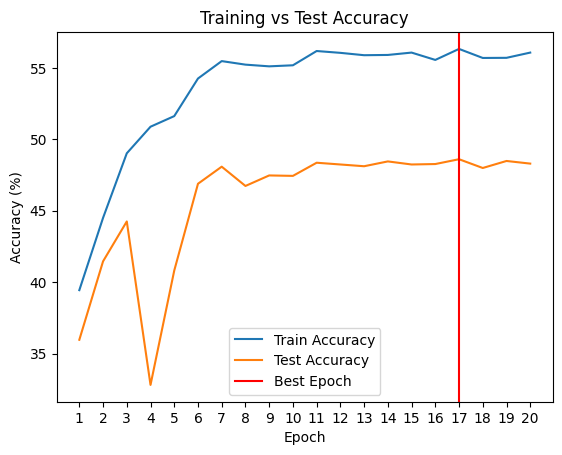

In [ ]:
model_cnn = MidiCNN().to(device)
model = model_cnn
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.1606 Train Acc: 47.68% Test Loss: 1.1328 Test Acc: 50.41%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0246 Train Acc: 55.14% Test Loss: 1.1684 Test Acc: 49.31%
Epoch [3/20] LR: 0.001000 Train Loss: 0.9778 Train Acc: 58.11% Test Loss: 1.1343 Test Acc: 51.43%
Epoch [4/20] LR: 0.001000 Train Loss: 0.9423 Train Acc: 59.81% Test Loss: 1.1029 Test Acc: 51.15%
Epoch [5/20] LR: 0.000100 Train Loss: 0.9000 Train Acc: 61.44% Test Loss: 1.1172 Test Acc: 53.91%
Epoch [6/20] LR: 0.000100 Train Loss: 0.8479 Train Acc: 64.61% Test Loss: 1.1292 Test Acc: 53.27%
Epoch [7/20] LR: 0.000100 Train Loss: 0.8351 Train Acc: 65.18% Test Loss: 1.1364 Test Acc: 54.10%
Epoch [8/20] LR: 0.000100 Train Loss: 0.8294 Train Acc: 65.37% Test Loss: 1.1446 Test Acc: 53.51%
Epoch [9/20] LR: 0.000100 Train Loss: 0.8225 Train Acc: 65.91% Test Loss: 1.1328 Test Acc: 53.02%
Epoch [10/20] LR: 0.000010 Train Loss: 0.8187 Train Acc: 66.08% Test Loss: 1.1395 Test Acc: 54.16%
Epoch [11/20] LR: 0

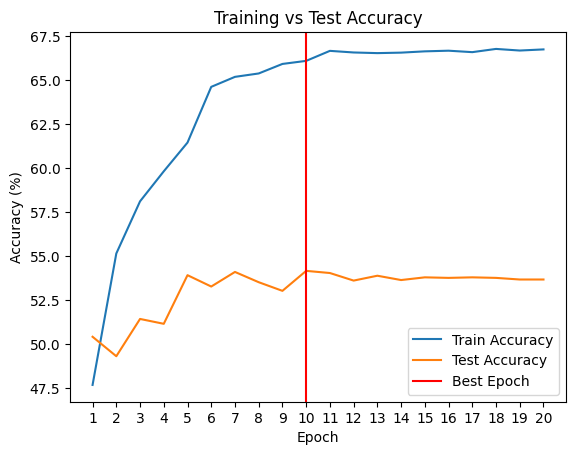

In [ ]:
model_rnn = MidiRNN().to(device)
model = model_rnn
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.1821 Train Acc: 48.22% Test Loss: 1.2089 Test Acc: 46.61%
Epoch [2/20] LR: 0.001000 Train Loss: 0.9992 Train Acc: 59.77% Test Loss: 1.2767 Test Acc: 45.75%
Epoch [3/20] LR: 0.001000 Train Loss: 0.9140 Train Acc: 64.07% Test Loss: 1.2803 Test Acc: 46.15%
Epoch [4/20] LR: 0.001000 Train Loss: 0.8505 Train Acc: 67.71% Test Loss: 1.3023 Test Acc: 45.38%
Epoch [5/20] LR: 0.000100 Train Loss: 0.7955 Train Acc: 70.59% Test Loss: 1.3166 Test Acc: 46.18%
Epoch [6/20] LR: 0.000100 Train Loss: 0.7045 Train Acc: 75.83% Test Loss: 1.3185 Test Acc: 45.87%
Epoch [7/20] LR: 0.000100 Train Loss: 0.6933 Train Acc: 76.43% Test Loss: 1.3215 Test Acc: 45.50%
Epoch [8/20] LR: 0.000100 Train Loss: 0.6874 Train Acc: 76.93% Test Loss: 1.3212 Test Acc: 45.66%
Epoch [9/20] LR: 0.000100 Train Loss: 0.6823 Train Acc: 76.99% Test Loss: 1.3263 Test Acc: 45.26%
Epoch [10/20] LR: 0.000010 Train Loss: 0.6783 Train Acc: 77.24% Test Loss: 1.3227 Test Acc: 45.84%
Epoch [11/20] LR: 0

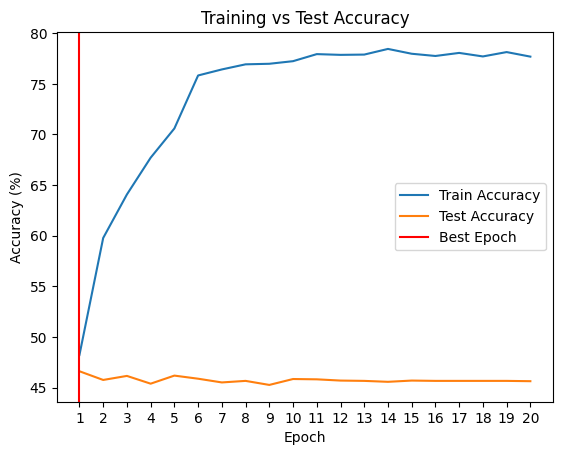

In [ ]:
model_fcn = MidiFCN().to(device)
model = model_fcn
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.1529 Train Acc: 47.14% Test Loss: 1.1880 Test Acc: 47.19%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0173 Train Acc: 55.79% Test Loss: 1.1676 Test Acc: 46.70%
Epoch [3/20] LR: 0.001000 Train Loss: 0.9668 Train Acc: 58.64% Test Loss: 1.1845 Test Acc: 51.52%
Epoch [4/20] LR: 0.001000 Train Loss: 0.9540 Train Acc: 58.89% Test Loss: 1.1608 Test Acc: 49.31%
Epoch [5/20] LR: 0.000100 Train Loss: 0.9045 Train Acc: 61.49% Test Loss: 1.1540 Test Acc: 52.56%
Epoch [6/20] LR: 0.000100 Train Loss: 0.8490 Train Acc: 64.46% Test Loss: 1.1415 Test Acc: 52.68%
Epoch [7/20] LR: 0.000100 Train Loss: 0.8350 Train Acc: 64.86% Test Loss: 1.1459 Test Acc: 53.51%
Epoch [8/20] LR: 0.000100 Train Loss: 0.8286 Train Acc: 65.25% Test Loss: 1.1496 Test Acc: 52.96%
Epoch [9/20] LR: 0.000100 Train Loss: 0.8191 Train Acc: 65.94% Test Loss: 1.1573 Test Acc: 52.75%
Epoch [10/20] LR: 0.000010 Train Loss: 0.8112 Train Acc: 66.06% Test Loss: 1.1576 Test Acc: 53.18%
Epoch [11/20] LR: 0

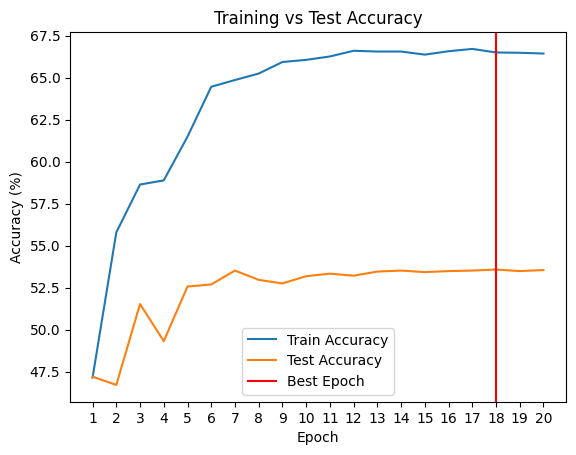

In [ ]:
model_rnn_lstm = MidiRNN(rnn_type='ltsm').to(device)
model = model_rnn_lstm
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.2016 Train Acc: 43.65% Test Loss: 1.2516 Test Acc: 40.29%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0955 Train Acc: 50.96% Test Loss: 1.1756 Test Acc: 44.98%
Epoch [3/20] LR: 0.001000 Train Loss: 1.0003 Train Acc: 56.67% Test Loss: 1.1091 Test Acc: 50.20%
Epoch [4/20] LR: 0.001000 Train Loss: 0.9366 Train Acc: 59.77% Test Loss: 1.2041 Test Acc: 50.91%
Epoch [5/20] LR: 0.000100 Train Loss: 0.9096 Train Acc: 60.76% Test Loss: 1.5728 Test Acc: 40.01%
Epoch [6/20] LR: 0.000100 Train Loss: 0.8604 Train Acc: 63.54% Test Loss: 0.9861 Test Acc: 57.53%
Epoch [7/20] LR: 0.000100 Train Loss: 0.8377 Train Acc: 64.80% Test Loss: 0.9679 Test Acc: 57.07%
Epoch [8/20] LR: 0.000100 Train Loss: 0.8326 Train Acc: 65.31% Test Loss: 1.0610 Test Acc: 52.84%
Epoch [9/20] LR: 0.000100 Train Loss: 0.8194 Train Acc: 66.12% Test Loss: 0.9637 Test Acc: 58.98%
Epoch [10/20] LR: 0.000010 Train Loss: 0.8182 Train Acc: 66.24% Test Loss: 1.0779 Test Acc: 52.16%
Epoch [11/20] LR: 0

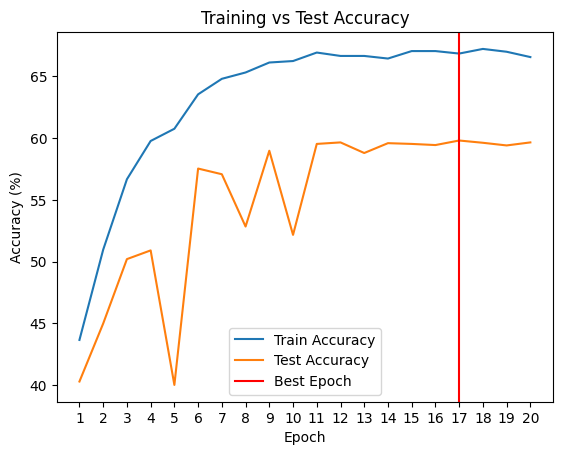

In [ ]:
model_cnn_1 = MidiCNN(blocks=[
    {'c': 32,  'k': (9, 7), 's': (1, 2), 'p': (4, 3)},
    {'c': 64,  'k': (9, 5), 's': (1, 2), 'p': (4, 2)},
    {'c': 128, 'k': (5, 3), 's': (1, 2), 'p': (2, 1)},
]).to(device)
model = model_cnn_1
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.2049 Train Acc: 44.49% Test Loss: 1.3264 Test Acc: 36.45%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0586 Train Acc: 53.60% Test Loss: 1.2885 Test Acc: 43.48%
Epoch [3/20] LR: 0.001000 Train Loss: 0.9882 Train Acc: 57.37% Test Loss: 1.0741 Test Acc: 49.92%
Epoch [4/20] LR: 0.001000 Train Loss: 0.9642 Train Acc: 58.37% Test Loss: 1.1404 Test Acc: 51.55%
Epoch [5/20] LR: 0.000100 Train Loss: 0.9259 Train Acc: 60.51% Test Loss: 2.6980 Test Acc: 31.08%
Epoch [6/20] LR: 0.000100 Train Loss: 0.8644 Train Acc: 64.68% Test Loss: 1.2637 Test Acc: 47.32%
Epoch [7/20] LR: 0.000100 Train Loss: 0.8510 Train Acc: 65.46% Test Loss: 1.0316 Test Acc: 54.28%
Epoch [8/20] LR: 0.000100 Train Loss: 0.8402 Train Acc: 65.73% Test Loss: 0.9927 Test Acc: 58.09%
Epoch [9/20] LR: 0.000100 Train Loss: 0.8333 Train Acc: 66.13% Test Loss: 0.9810 Test Acc: 57.96%
Epoch [10/20] LR: 0.000010 Train Loss: 0.8257 Train Acc: 66.73% Test Loss: 1.0579 Test Acc: 55.63%
Epoch [11/20] LR: 0

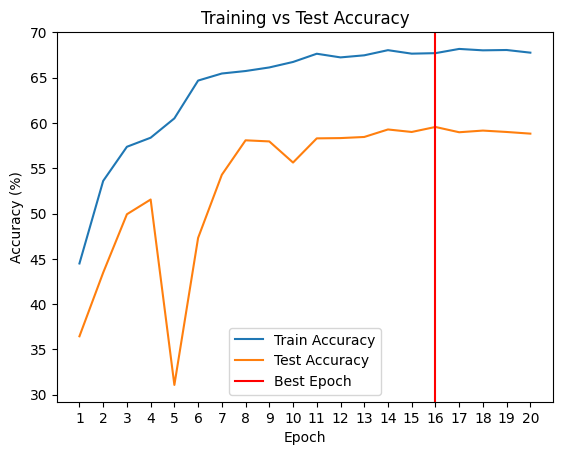

In [ ]:
model_cnn_2 = MidiCNN(blocks=[
    {'c': 32,  'k': (5, 15), 's': (1, 2), 'p': (2, 7)},
    {'c': 64,  'k': (5, 11), 's': (1, 2), 'p': (2, 5)},
    {'c': 128, 'k': (3,  7), 's': (1, 2), 'p': (1, 3)},
]).to(device)
model = model_cnn_2
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.1970 Train Acc: 44.62% Test Loss: 1.4493 Test Acc: 31.94%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0947 Train Acc: 51.45% Test Loss: 2.1156 Test Acc: 35.44%
Epoch [3/20] LR: 0.001000 Train Loss: 1.0037 Train Acc: 55.99% Test Loss: 1.8418 Test Acc: 33.66%
Epoch [4/20] LR: 0.001000 Train Loss: 0.9380 Train Acc: 59.10% Test Loss: 2.0010 Test Acc: 34.98%
Epoch [5/20] LR: 0.000100 Train Loss: 0.9074 Train Acc: 60.60% Test Loss: 1.3661 Test Acc: 40.10%
Epoch [6/20] LR: 0.000100 Train Loss: 0.8530 Train Acc: 64.35% Test Loss: 1.0093 Test Acc: 56.49%
Epoch [7/20] LR: 0.000100 Train Loss: 0.8263 Train Acc: 64.99% Test Loss: 1.0886 Test Acc: 53.51%
Epoch [8/20] LR: 0.000100 Train Loss: 0.8204 Train Acc: 65.41% Test Loss: 1.0869 Test Acc: 51.46%
Epoch [9/20] LR: 0.000100 Train Loss: 0.8137 Train Acc: 66.06% Test Loss: 0.9882 Test Acc: 57.75%
Epoch [10/20] LR: 0.000010 Train Loss: 0.8027 Train Acc: 66.47% Test Loss: 1.0599 Test Acc: 53.70%
Epoch [11/20] LR: 0

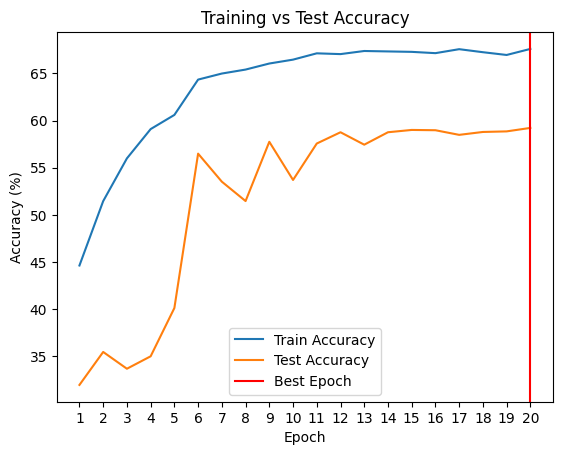

In [ ]:
model_cnn_3 = MidiCNN(blocks=[
    {'c': 32,  'k': (12, 7), 's': (1, 2), 'p': (6, 3)},
    {'c': 64,  'k': (9,  5), 's': (1, 2), 'p': (4, 2)},
    {'c': 128, 'k': (5,  3), 's': (1, 2), 'p': (2, 1)},
]).to(device)
model = model_cnn_3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.2141 Train Acc: 43.54% Test Loss: 1.1895 Test Acc: 46.89%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0922 Train Acc: 52.12% Test Loss: 1.2743 Test Acc: 46.55%
Epoch [3/20] LR: 0.001000 Train Loss: 1.0391 Train Acc: 54.80% Test Loss: 1.1631 Test Acc: 51.52%
Epoch [4/20] LR: 0.001000 Train Loss: 0.9825 Train Acc: 56.88% Test Loss: 1.1562 Test Acc: 52.16%
Epoch [5/20] LR: 0.000100 Train Loss: 0.9505 Train Acc: 58.82% Test Loss: 1.1590 Test Acc: 51.86%
Epoch [6/20] LR: 0.000100 Train Loss: 0.9036 Train Acc: 61.17% Test Loss: 1.1232 Test Acc: 52.50%
Epoch [7/20] LR: 0.000100 Train Loss: 0.8906 Train Acc: 61.98% Test Loss: 1.1154 Test Acc: 52.35%
Epoch [8/20] LR: 0.000100 Train Loss: 0.8824 Train Acc: 62.03% Test Loss: 1.1401 Test Acc: 53.15%
Epoch [9/20] LR: 0.000100 Train Loss: 0.8784 Train Acc: 62.55% Test Loss: 1.1321 Test Acc: 52.99%
Epoch [10/20] LR: 0.000010 Train Loss: 0.8723 Train Acc: 62.42% Test Loss: 1.1172 Test Acc: 51.80%
Epoch [11/20] LR: 0

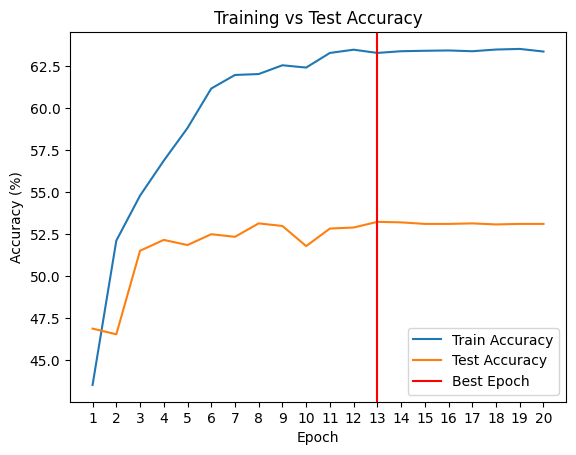

In [ ]:
model_rnn_2 = MidiRNN(temporal_pool='last').to(device)
model = model_rnn_2
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.1282 Train Acc: 49.32% Test Loss: 1.2314 Test Acc: 49.22%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0140 Train Acc: 56.71% Test Loss: 1.1522 Test Acc: 48.94%
Epoch [3/20] LR: 0.001000 Train Loss: 0.9589 Train Acc: 58.90% Test Loss: 1.1303 Test Acc: 50.94%
Epoch [4/20] LR: 0.001000 Train Loss: 0.8998 Train Acc: 62.13% Test Loss: 1.1605 Test Acc: 51.55%
Epoch [5/20] LR: 0.000100 Train Loss: 0.8520 Train Acc: 64.53% Test Loss: 1.1474 Test Acc: 54.96%
Epoch [6/20] LR: 0.000100 Train Loss: 0.7814 Train Acc: 67.31% Test Loss: 1.1301 Test Acc: 54.96%
Epoch [7/20] LR: 0.000100 Train Loss: 0.7585 Train Acc: 68.60% Test Loss: 1.1252 Test Acc: 56.46%
Epoch [8/20] LR: 0.000100 Train Loss: 0.7467 Train Acc: 69.09% Test Loss: 1.1368 Test Acc: 56.15%
Epoch [9/20] LR: 0.000100 Train Loss: 0.7344 Train Acc: 69.52% Test Loss: 1.1432 Test Acc: 57.26%
Epoch [10/20] LR: 0.000010 Train Loss: 0.7256 Train Acc: 69.73% Test Loss: 1.1359 Test Acc: 56.21%
Epoch [11/20] LR: 0

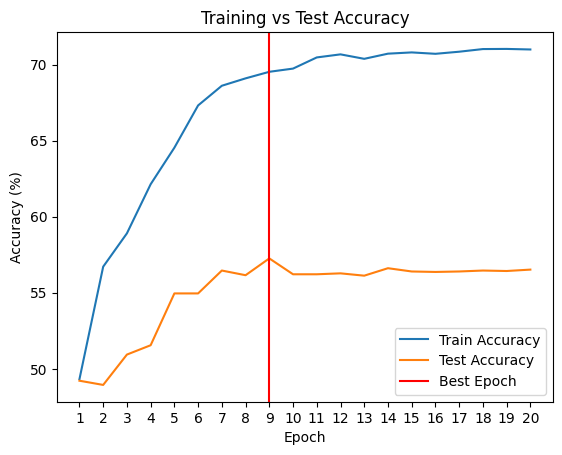

In [ ]:
model_rnn_3 = MidiRNN(hidden_size=256).to(device)
model = model_rnn_3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/20] LR: 0.001000 Train Loss: 1.1269 Train Acc: 48.77% Test Loss: 1.2481 Test Acc: 46.85%
Epoch [2/20] LR: 0.001000 Train Loss: 1.0047 Train Acc: 56.68% Test Loss: 1.2046 Test Acc: 50.14%
Epoch [3/20] LR: 0.001000 Train Loss: 0.9533 Train Acc: 59.24% Test Loss: 1.1436 Test Acc: 53.42%
Epoch [4/20] LR: 0.001000 Train Loss: 0.8895 Train Acc: 62.43% Test Loss: 1.1483 Test Acc: 51.37%
Epoch [5/20] LR: 0.000100 Train Loss: 0.8470 Train Acc: 64.22% Test Loss: 1.1535 Test Acc: 51.95%
Epoch [6/20] LR: 0.000100 Train Loss: 0.7583 Train Acc: 68.24% Test Loss: 1.1320 Test Acc: 55.88%
Epoch [7/20] LR: 0.000100 Train Loss: 0.7225 Train Acc: 70.00% Test Loss: 1.1290 Test Acc: 56.86%
Epoch [8/20] LR: 0.000100 Train Loss: 0.7019 Train Acc: 70.65% Test Loss: 1.1455 Test Acc: 55.26%
Epoch [9/20] LR: 0.000100 Train Loss: 0.6881 Train Acc: 71.34% Test Loss: 1.1329 Test Acc: 56.24%
Epoch [10/20] LR: 0.000010 Train Loss: 0.6741 Train Acc: 71.90% Test Loss: 1.1473 Test Acc: 56.83%
Epoch [11/20] LR: 0

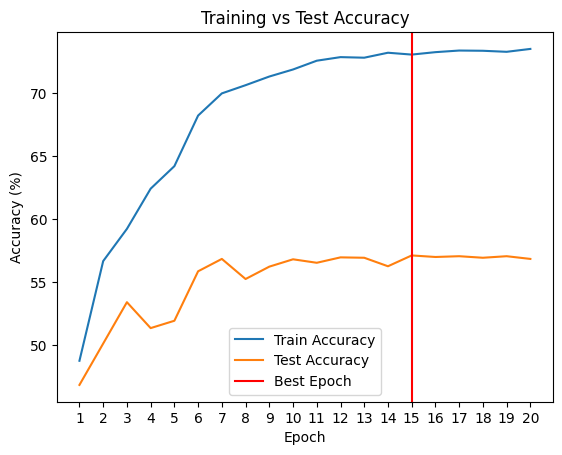

In [ ]:
model_rnn_3 = MidiRNN(hidden_size=256, num_layers=3).to(device)
model = model_rnn_3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=20, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/10] LR: 0.001000 Train Loss: 1.1420 Train Acc: 47.72% Test Loss: 1.1502 Test Acc: 50.91%
Epoch [2/10] LR: 0.001000 Train Loss: 1.0111 Train Acc: 56.10% Test Loss: 1.1768 Test Acc: 46.95%
Epoch [3/10] LR: 0.001000 Train Loss: 0.9314 Train Acc: 60.43% Test Loss: 1.1474 Test Acc: 50.23%
Epoch [4/10] LR: 0.001000 Train Loss: 0.8604 Train Acc: 63.54% Test Loss: 1.1333 Test Acc: 54.53%
Epoch [5/10] LR: 0.000100 Train Loss: 0.7884 Train Acc: 66.55% Test Loss: 1.1984 Test Acc: 55.14%
Epoch [6/10] LR: 0.000100 Train Loss: 0.6619 Train Acc: 72.78% Test Loss: 1.1175 Test Acc: 55.69%
Epoch [7/10] LR: 0.000100 Train Loss: 0.6028 Train Acc: 75.41% Test Loss: 1.1239 Test Acc: 56.46%
Epoch [8/10] LR: 0.000100 Train Loss: 0.5647 Train Acc: 77.56% Test Loss: 1.1455 Test Acc: 56.55%
Epoch [9/10] LR: 0.000100 Train Loss: 0.5309 Train Acc: 79.22% Test Loss: 1.1755 Test Acc: 57.20%
Epoch [10/10] LR: 0.000010 Train Loss: 0.4984 Train Acc: 80.41% Test Loss: 1.1635 Test Acc: 57.04%


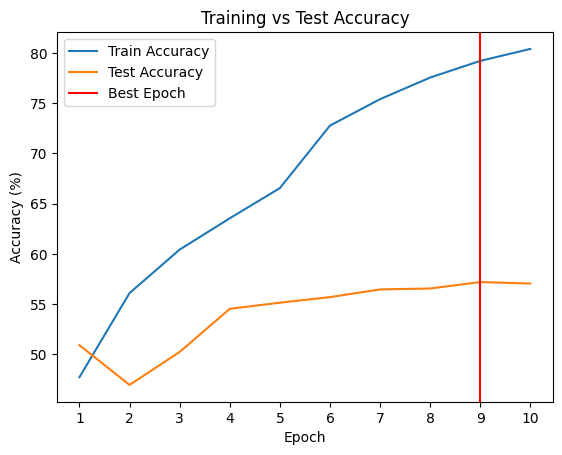

In [ ]:
model_rnn_4 = MidiRNN(hidden_size=512, num_layers=4).to(device)
model = model_rnn_4
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=10, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Epoch [1/10] LR: 0.000100 Train Loss: 0.5002 Train Acc: 80.30% Test Loss: 1.1809 Test Acc: 57.23%
Epoch [2/10] LR: 0.000100 Train Loss: 0.4688 Train Acc: 81.69% Test Loss: 1.2281 Test Acc: 56.12%
Epoch [3/10] LR: 0.000100 Train Loss: 0.4406 Train Acc: 83.12% Test Loss: 1.2412 Test Acc: 56.77%
Epoch [4/10] LR: 0.000100 Train Loss: 0.4170 Train Acc: 84.26% Test Loss: 1.2922 Test Acc: 56.64%
Epoch [5/10] LR: 0.000010 Train Loss: 0.3864 Train Acc: 85.51% Test Loss: 1.3257 Test Acc: 56.58%
Epoch [6/10] LR: 0.000010 Train Loss: 0.3474 Train Acc: 87.48% Test Loss: 1.3278 Test Acc: 57.50%
Epoch [7/10] LR: 0.000010 Train Loss: 0.3353 Train Acc: 88.13% Test Loss: 1.3318 Test Acc: 57.13%
Epoch [8/10] LR: 0.000010 Train Loss: 0.3315 Train Acc: 88.28% Test Loss: 1.3420 Test Acc: 57.38%
Epoch [9/10] LR: 0.000010 Train Loss: 0.3262 Train Acc: 88.43% Test Loss: 1.3570 Test Acc: 57.59%
Epoch [10/10] LR: 0.000001 Train Loss: 0.3211 Train Acc: 88.53% Test Loss: 1.3642 Test Acc: 57.53%


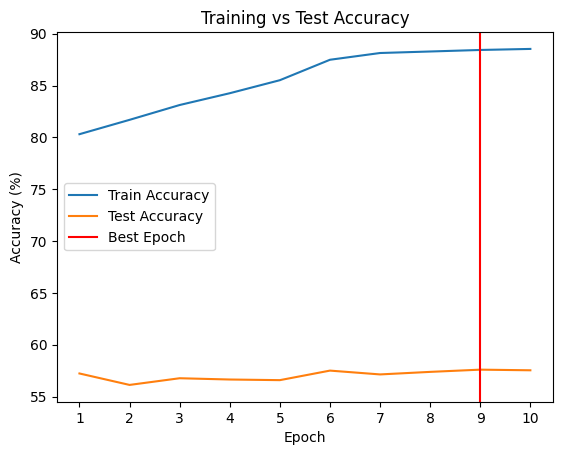

In [ ]:
model = model_rnn_4
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_epoch, train_acc_history, test_acc_history = train_model(model, optimizer, num_epochs=10, scheduler=scheduler)
plot_train(best_epoch, train_acc_history, test_acc_history)


Classification report:
              precision    recall  f1-score   support

        Bach      0.637     0.677     0.656       715
   Beethoven      0.496     0.465     0.480       843
      Chopin      0.801     0.710     0.753       955
      Mozart      0.458     0.529     0.491       746

    accuracy                          0.598      3259
   macro avg      0.598     0.595     0.595      3259
weighted avg      0.608     0.598     0.601      3259



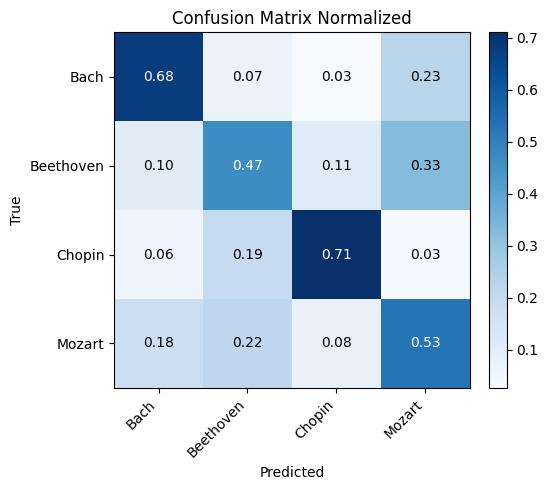

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, loader, device, class_names=None, normalize=None):
  model.eval()
  all_preds, all_targets = [], []

  with torch.inference_mode():
    for inputs, targets in loader:
      inputs  = inputs.to(device, non_blocking=True)
      targets = targets.to(device, non_blocking=True)
      outputs = model(inputs)
      preds = outputs.argmax(dim=1)
      all_preds.append(preds.cpu().numpy())
      all_targets.append(targets.cpu().numpy())

  y_pred = np.concatenate(all_preds)
  y_true = np.concatenate(all_targets)

  cm = confusion_matrix(y_true, y_pred, normalize=normalize)

  if class_names is not None:
    print('\nClassification report:')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

  return cm

def plot_confusion_matrix(cm, class_names=None, title='Confusion Matrix'):
  fig, ax = plt.subplots(figsize=(6, 5))
  im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
  ax.set_title(title)
  plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

  if class_names is not None:
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
  else:
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

  fmt = '.2f' if cm.dtype.kind == 'f' else 'd'
  thresh = cm.max() / 2.0
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
        color='white' if cm[i, j] > thresh else 'black')
  plt.tight_layout()
  plt.show()

class_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
cm = compute_confusion_matrix(model_cnn_1, test_loader, device, class_names=class_names, normalize='true')
plot_confusion_matrix(cm, class_names, title='Confusion Matrix Normalized')



Classification report:
              precision    recall  f1-score   support

        Bach      0.660     0.585     0.620       715
   Beethoven      0.454     0.445     0.449       843
      Chopin      0.665     0.663     0.664       955
      Mozart      0.514     0.584     0.547       746

    accuracy                          0.571      3259
   macro avg      0.573     0.569     0.570      3259
weighted avg      0.575     0.571     0.572      3259



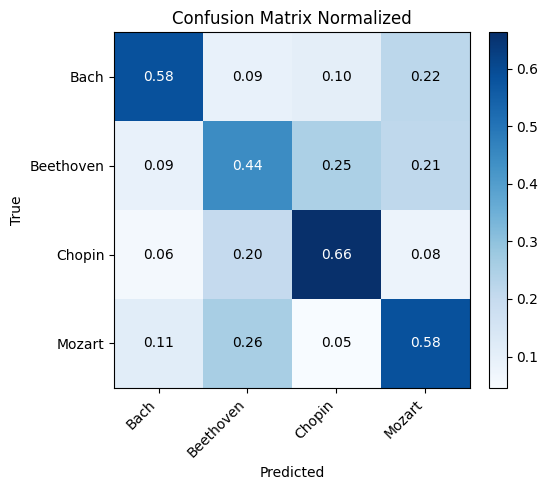

In [ ]:
cm = compute_confusion_matrix(model_rnn_3, test_loader, device, class_names=class_names, normalize='true')
plot_confusion_matrix(cm, class_names, title='Confusion Matrix Normalized')